In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import time

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

import math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
data_list = glob.glob('./data/archive/img_align_celeba/img_align_celeba/*.jpg')

In [11]:
## 데이터
class SRdataset(Dataset):
  def __init__(self, paths):
    self.paths = paths        

  def __len__(self):
    return len(self.paths)

  def __getitem__(self,idx):
    path = self.paths[idx]

    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(40, 40), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    inp = cv2.GaussianBlur(img,(0,0),1)
    img = np.transpose(img, (2,0,1)) # 배열 전치 방향 수정
    inp = np.transpose(inp, (2,0,1)) # 배열 전치 방향 수정

    input_sample, label_sample = torch.tensor(inp, dtype=torch.float32), torch.tensor(img, dtype=torch.float32)

    return input_sample,label_sample

In [12]:
train_ds = SRdataset(data_list)
train_dl = DataLoader(train_ds, batch_size=64)

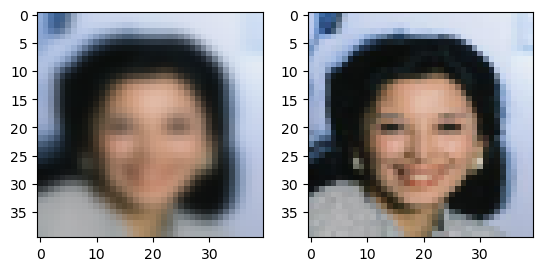

In [13]:
for image, label in train_dl:
    img = image[3]
    lab = label[3]
    break

plt.subplot(1,2,1)
plt.imshow(np.transpose(img, (1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(lab, (1,2,0)))

In [14]:
## 모델 생성
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # padding_mode='replicate'는 zero padding이 아닌, 주변 값을 복사해서 padding 처리 합니다.
        self.conv1 = nn.Conv2d(3, 64, 9, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(64, 32, 1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 3, 5, padding=2, padding_mode='replicate')
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        
        return x

## 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__ # 현재 클래스의 이름을 참조 합니다.
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

model = SRCNN().to(device)
model.apply(initialize_weights);
model

## 손실함수
loss_func = nn.MSELoss() # denoising과 같은 image restoration task 에서는 image 간의 차이나 segmentation 에서는 mask 간의 차이를 구하기 위해 주로 사용되어 사용했습니다.
optimizer = optim.Adam(model.parameters())

In [15]:
## PSNR function
# 모델의 출력값과 high-resoultion의 유사도를 측정하며, PSNR 값이 클수록 좋습니다.
def psnr(label, outputs, max_val=1.):
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff)**2))
    if rmse == 0: # label과 output이 완전히 일치하는 경우
        return 100
    else:
        psnr = 20 * math.log10(max_val/rmse)
        return psnr

In [16]:
## Training
def train_step(model, data_dl):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0

    for i, (image, label) in enumerate(data_dl):
        optimizer.zero_grad()
            
        image = image.to(device)
        label = label.to(device)

        outputs = model(image)
        loss = loss_func(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_psnr = psnr(label, outputs)
        running_psnr += batch_psnr
  
    final_loss = running_loss / len(data_dl.dataset)
    final_psnr = running_psnr / int(len(train_ds)/data_dl.batch_size)
    return final_loss, final_psnr

In [17]:
num_epochs = 20

train_loss = []
train_psnr = []
start = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} of {num_epochs}')
    train_epoch_loss, train_epoch_psnr = train_step(model, train_dl)

    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    end = time.time()
    print(f'Train PSNR: {train_epoch_psnr:.3f}, Time: {end-start:.2f} sec')

Epoch 1 of 20
Train PSNR: 24.577, Time: 1484.78 sec
Epoch 2 of 20
Train PSNR: 26.357, Time: 2864.14 sec
Epoch 3 of 20
Train PSNR: 26.950, Time: 5317.58 sec
Epoch 4 of 20
Train PSNR: 27.555, Time: 6475.57 sec
Epoch 5 of 20
Train PSNR: 28.107, Time: 7637.86 sec
Epoch 6 of 20
Train PSNR: 28.415, Time: 8961.19 sec
Epoch 7 of 20
Train PSNR: 28.557, Time: 10276.34 sec
Epoch 8 of 20
Train PSNR: 28.713, Time: 11554.98 sec
Epoch 9 of 20
Train PSNR: 28.122, Time: 12730.80 sec
Epoch 10 of 20
Train PSNR: 28.222, Time: 13888.97 sec
Epoch 11 of 20
Train PSNR: 28.516, Time: 15043.26 sec
Epoch 12 of 20
Train PSNR: 28.693, Time: 16193.50 sec
Epoch 13 of 20
Train PSNR: 28.478, Time: 17351.47 sec
Epoch 14 of 20
Train PSNR: 28.301, Time: 18509.28 sec
Epoch 15 of 20
Train PSNR: 28.791, Time: 19666.57 sec
Epoch 16 of 20
Train PSNR: 28.959, Time: 20835.19 sec
Epoch 17 of 20
Train PSNR: 29.064, Time: 21987.55 sec
Epoch 18 of 20
Train PSNR: 29.121, Time: 23247.23 sec
Epoch 19 of 20
Train PSNR: 29.194, Time: 24

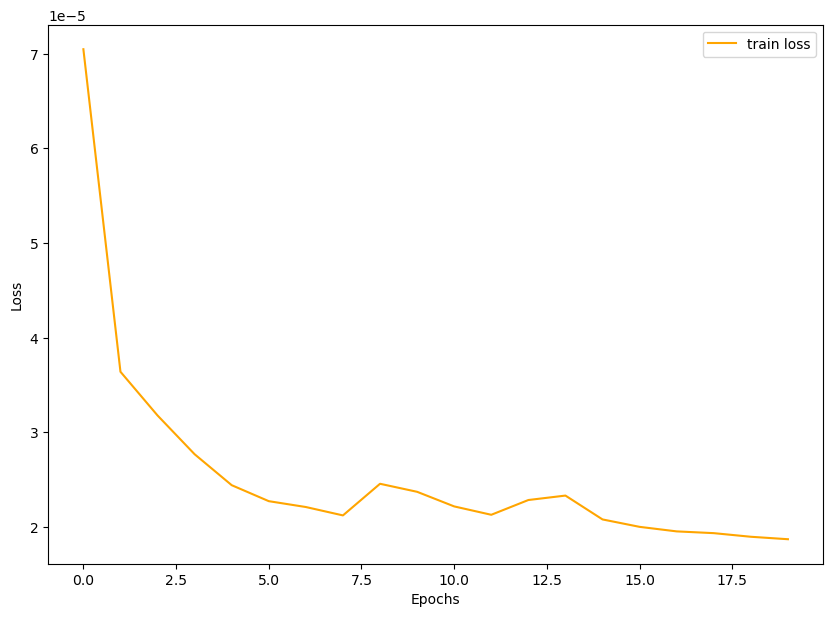

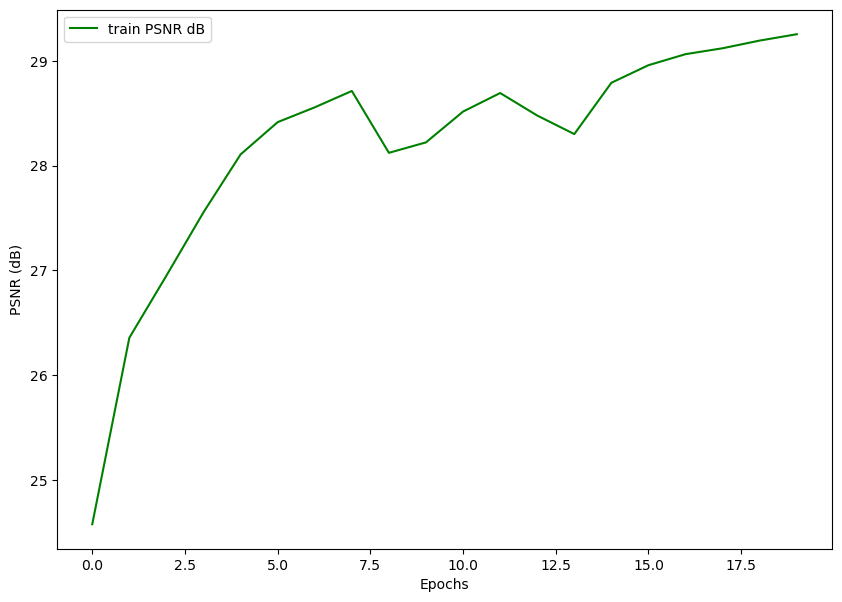

In [19]:
torch.save(model, 'SRCNN_model.pt')

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'origingal')

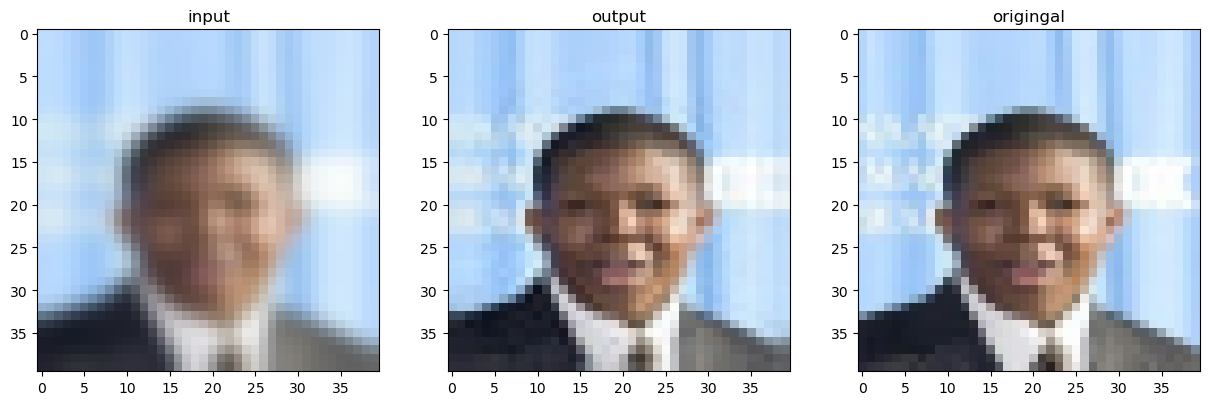

In [22]:
for img, label in train_dl:
    img = img[7]
    label = label[7]
    break

model.eval() # evaluation과정에서 사용하지 않을 layer들을 사용하지 않도록 해줍니다.
with torch.no_grad():
    img_ = img.unsqueeze(0)
    img_ = img_.to(device)
    output = model(img_)
    output = output.squeeze(0)

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(np.transpose(img, (1,2,0)))
plt.title('input')
plt.subplot(1,3,2)
plt.imshow(np.transpose(output.cpu(), (1,2,0)))
plt.title('output')
plt.subplot(1,3,3)
plt.imshow(np.transpose(label, (1,2,0)))
plt.title('origingal')